<a href="https://colab.research.google.com/github/costpetrides/Quantum-Classical-Navier-Stokes/blob/main/Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

not going to converge!
Final Iteration = 4; Residual = 11.815893459410113


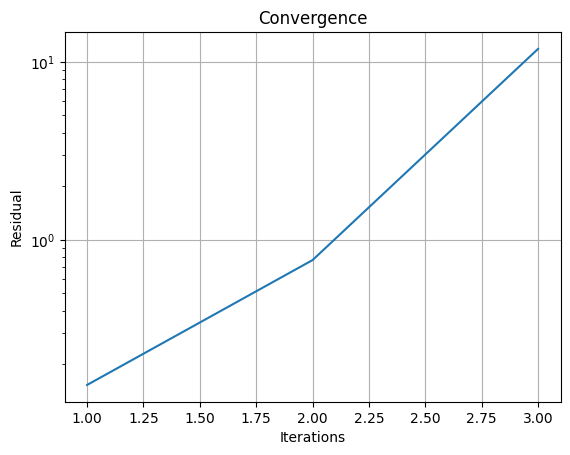

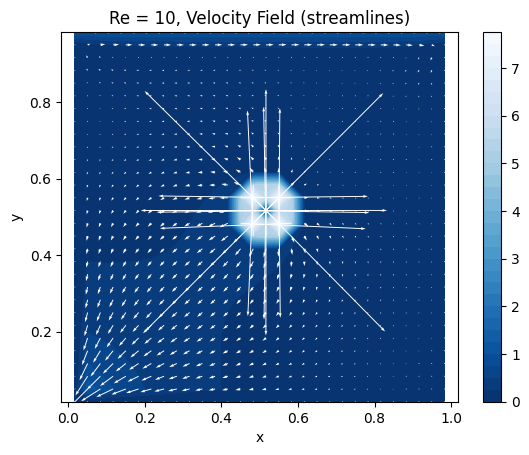

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# --- u_momentum ---
def u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p, velocity, alpha):
    u_star = np.zeros((imax + 1, jmax))
    d_u = np.zeros((imax + 1, jmax))
    De = mu * dy / dx
    Dw = mu * dy / dx
    Dn = mu * dx / dy
    Ds = mu * dx / dy
    def A(F, D): return max(0, (1 - 0.1 * abs(F / D))**5)
    for i in range(1, imax):
        for j in range(1, jmax - 1):
            Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
            Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
            Fn = 0.5 * rho * dx * (v[i, j + 1] + v[i - 1, j + 1])
            Fs = 0.5 * rho * dx * (v[i, j] + v[i - 1, j])
            aE = De * A(Fe, De) + max(-Fe, 0)
            aW = Dw * A(Fw, Dw) + max(Fw, 0)
            aN = Dn * A(Fn, Dn) + max(-Fn, 0)
            aS = Ds * A(Fs, Ds) + max(Fs, 0)
            aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
            pressure_term = (p[i - 1, j] - p[i, j]) * dy
            u_star[i, j] = alpha / aP * ((aE * u[i + 1, j] + aW * u[i - 1, j] + aN * u[i, j + 1] + aS * u[i, j - 1]) + pressure_term) + (1 - alpha) * u[i, j]
            d_u[i, j] = alpha * dy / aP
    # BCs for top and bottom (d_u)
    for i in range(1, imax):
        j = 0
        Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
        Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
        Fn = 0.5 * rho * dx * (v[i, j + 1] + v[i - 1, j + 1])
        Fs = 0
        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = 0
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_u[i, j] = alpha * dy / aP
        j = jmax - 1
        Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i, j])
        Fw = 0.5 * rho * dy * (u[i - 1, j] + u[i, j])
        Fn = 0
        Fs = 0.5 * rho * dx * (v[i, j] + v[i - 1, j])
        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = 0
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_u[i, j] = alpha * dy / aP
    # Velocity BCs for u_star
    u_star[0, :jmax] = -u_star[1, :jmax]            # left wall
    u_star[imax, :jmax] = -u_star[imax - 1, :jmax]  # right wall
    u_star[:, 0] = 0.0                               # bottom wall
    u_star[:, jmax - 1] = velocity                   # top wall
    return u_star, d_u

# --- v_momentum ---
def v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p, alpha):
    v_star = np.zeros((imax, jmax + 1))
    d_v = np.zeros((imax, jmax + 1))
    De = mu * dy / dx
    Dw = mu * dy / dx
    Dn = mu * dx / dy
    Ds = mu * dx / dy
    A = lambda F, D: max(0, (1 - 0.1 * abs(F / D))**5)
    for i in range(1, imax - 1):
        for j in range(1, jmax):
            Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i + 1, j - 1])
            Fw = 0.5 * rho * dy * (u[i, j] + u[i, j - 1])
            Fn = 0.5 * rho * dx * (v[i, j] + v[i, j + 1])
            Fs = 0.5 * rho * dx * (v[i, j - 1] + v[i, j])
            aE = De * A(Fe, De) + max(-Fe, 0)
            aW = Dw * A(Fw, Dw) + max(Fw, 0)
            aN = Dn * A(Fn, Dn) + max(-Fn, 0)
            aS = Ds * A(Fs, Ds) + max(Fs, 0)
            aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
            pressure_term = (p[i, j - 1] - p[i, j]) * dx
            v_star[i, j] = alpha / aP * (aE * v[i + 1, j] + aW * v[i - 1, j] + aN * v[i, j + 1] + aS * v[i, j - 1] + pressure_term) + (1 - alpha) * v[i, j]
            d_v[i, j] = alpha * dx / aP
    # BCs for left and right (d_v)
    for j in range(1, jmax):
        i = 0
        Fe = 0.5 * rho * dy * (u[i + 1, j] + u[i + 1, j - 1])
        Fw = 0
        Fn = 0.5 * rho * dx * (v[i, j] + v[i, j + 1])
        Fs = 0.5 * rho * dx * (v[i, j - 1] + v[i, j])
        aE = De * A(Fe, De) + max(-Fe, 0)
        aW = 0
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_v[i, j] = alpha * dx / aP
        i = imax - 1
        Fe = 0
        Fw = 0.5 * rho * dy * (u[i, j] + u[i, j - 1])
        Fn = 0.5 * rho * dx * (v[i, j] + v[i, j + 1])
        Fs = 0.5 * rho * dx * (v[i, j - 1] + v[i, j])
        aE = 0
        aW = Dw * A(Fw, Dw) + max(Fw, 0)
        aN = Dn * A(Fn, Dn) + max(-Fn, 0)
        aS = Ds * A(Fs, Ds) + max(Fs, 0)
        aP = aE + aW + aN + aS + (Fe - Fw) + (Fn - Fs)
        d_v[i, j] = alpha * dx / aP
    v_star[0, :] = 0.0          # left wall
    v_star[imax - 1, :] = 0.0   # right wall
    v_star[:, 0] = -v_star[:, 1]    # bottom wall
    v_star[:, jmax] = -v_star[:, jmax - 1]  # top wall
    return v_star, d_v

# --- get_rhs ---
def get_rhs(imax, jmax, dx, dy, rho, u_star, v_star):
    stride = jmax
    bp = np.zeros(imax * jmax)
    for j in range(jmax):
        for i in range(imax):
            pos = i + j * stride
            bp[pos] = rho * (u_star[i, j] * dy - u_star[i + 1, j] * dy + v_star[i, j] * dx - v_star[i, j + 1] * dx)
    bp[0] = 0
    return bp

# --- get_coeff_mat ---
def get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v):
    N = imax * jmax
    stride = jmax
    Ap = lil_matrix((N, N))
    for j in range(jmax):
        for i in range(imax):
            pos = i + j * stride
            if i == 0 and j == 0:
                Ap[pos, pos] = 1.0
                continue
            aE = aW = aN = aS = 0.0
            if i < imax - 1:
                aE = -rho * d_u[i + 1, j] * dy
                Ap[pos, pos + 1] = aE
            if i > 0:
                aW = -rho * d_u[i, j] * dy
                Ap[pos, pos - 1] = aW
            if j < jmax - 1:
                aN = -rho * d_v[i, j + 1] * dx
                Ap[pos, pos + stride] = aN
            if j > 0:
                aS = -rho * d_v[i, j] * dx
                Ap[pos, pos - stride] = aS
            Ap[pos, pos] = -(aE + aW + aN + aS)
    return Ap.tocsr()

# --- update_velocity ---
def update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity):
    u = np.zeros((imax + 1, jmax))
    v = np.zeros((imax, jmax + 1))
    for i in range(1, imax):
        for j in range(1, jmax - 1):
            u[i, j] = u_star[i, j] + d_u[i, j] * (p_prime[i - 1, j] - p_prime[i, j])
    for i in range(1, imax - 1):
        for j in range(1, jmax):
            v[i, j] = v_star[i, j] + d_v[i, j] * (p_prime[i, j - 1] - p_prime[i, j])
    v[0, :] = 0.0
    v[imax - 1, :] = 0.0
    v[:, 0] = -v[:, 1]
    v[:, -1] = -v[:, -2]
    u[0, :] = -u[1, :]
    u[imax, :] = -u[imax - 1, :]
    u[:, 0] = 0.0
    u[:, -1] = velocity
    return u, v

# --- check_divergence_free ---
def check_divergence_free(imax, jmax, dx, dy, u, v):
    div = np.zeros((imax, jmax))
    for i in range(imax):
        for j in range(jmax):
            div[i, j] = (1/dx) * (u[i, j] - u[i + 1, j]) + (1/dy) * (v[i, j] - v[i, j + 1])
    return div

# --- Quantum subregion solver stub (replace with VQE as needed) ---
def quantum_poisson_solver(A_block, rhs_block):
    # Replace this with quantum VQE solver if available!
    return np.linalg.solve(A_block, rhs_block)

# --- Main parameters and initialization ---
imax = 30
jmax = 30
max_iteration = 1000
max_res = 1000
rho = 1
velocity = 1
Re = 10
mu = 1 / Re
dx = 1 / (imax - 1)
dy = 1 / (jmax - 1)
alpha_p = 0.1
alpha_u = 0.7
tol = 1e-5

p = np.zeros((imax, jmax))
p_star = np.zeros_like(p)
p_prime = np.zeros_like(p)
rhsp = np.zeros(imax * jmax)

v_star = np.zeros((imax, jmax + 1))
v = np.zeros_like(v_star)
d_v = np.zeros_like(v_star)

u_star = np.zeros((imax + 1, jmax))
u = np.zeros_like(u_star)
d_u = np.zeros_like(u_star)

u_star[:, jmax - 1] = velocity
u[:, jmax - 1] = velocity

res_hist = []
iteration = 1

# --- Define subregion (e.g., 3x3 block at center) ---
block_size = 3
i0 = imax//2 - block_size//2
j0 = jmax//2 - block_size//2
i1 = i0 + block_size
j1 = j0 + block_size
stride = jmax
block_indices = []
for i in range(i0, i1):
    for j in range(j0, j1):
        pos = i + j * stride
        block_indices.append(pos)
block_indices = np.array(block_indices)

# --- Main SIMPLE Loop ---
while iteration <= max_iteration and max_res > tol:
    iteration += 1
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)
    u_old = u.copy()
    v_old = v.copy()
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    # --- HYBRID PRESSURE SOLVE ---
    Ap_block = Ap[block_indices[:, None], block_indices]
    rhsp_block = rhsp[block_indices]
    p_prime_block = quantum_poisson_solver(Ap_block.toarray(), rhsp_block)
    rhsp_classical = rhsp.copy()
    rhsp_classical[block_indices] = 0  # Zero out quantum region
    p_prime_classical = spsolve(Ap, rhsp_classical)
    p_prime_total = p_prime_classical.copy()
    p_prime_total[block_indices] = p_prime_block
    p_prime = np.zeros((imax, jmax))
    z = 0
    for j in range(jmax):
        for i in range(imax):
            p_prime[i, j] = p_prime_total[z]
            z += 1
    p = p_star + alpha_p * p_prime
    p[0, 0] = 0
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    div = check_divergence_free(imax, jmax, dx, dy, u, v)
    p_star = p.copy()
    u_res = np.max(np.abs(u - u_old))
    v_res = np.max(np.abs(v - v_old))
    max_res = max(u_res, v_res)
    res_hist.append(max_res)
    if iteration % 50 == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    if max_res > 5:
        print("not going to converge!")
        break

print(f"Final Iteration = {iteration}; Residual = {max_res}")

# --- Plots ---
plt.figure()
plt.plot(np.arange(1, iteration), res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence")
plt.yscale("log")
plt.grid(True)
plt.show()

x_p = np.linspace(dx / 2, 1 - dx / 2, imax)
y_p = np.linspace(dy / 2, 1 - dy / 2, jmax)
X_p, Y_p = np.meshgrid(x_p, y_p)
u_center = 0.5 * (u[0:imax, :] + u[1:imax + 1, :])
v_center = 0.5 * (v[:, 0:jmax] + v[:, 1:jmax + 1])
velocity_magnitude = np.sqrt(u_center**2 + v_center**2)
plt.figure()
plt.contourf(X_p, Y_p, velocity_magnitude.T, 32, cmap='Blues_r')
plt.colorbar()
plt.quiver(X_p, Y_p, u_center.T, v_center.T, color='w')
plt.title(f"Re = {Re}, Velocity Field (streamlines)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()